# Anomaly Detection 방법론
1. 통계적 기법(명확한 수학기반이라 설득용으로 활용, 다변량에 활용 불가) 
    - 3시그마  
    - box plot    
2. 거리·밀도 기반 이상 탐지  
    - 마할라노비스 거리
    - KNN 이상탐지
    - LOF 이상탐지
3. 분류 모델 기반 이상 탐지  
    - Isolation Forest
    - One-class SVM
    - Autoencoder
4. 차원축소·시각화 기반 이상 탐지  
    - PCA
    - t-SNE
5. 시계열 분해 기반 이상 탐지  
    - STL
    - Holt-winters

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

## 3-sigma Rule 이상탐지(통계적 기법)
___

* 정의
```
# SPC(Statistical Process Control, 통계적 공정관리), 경험적 규칙(empirical rule)
# 표준편차의 3배인 3*Sigma(σ)의 범위가 전체 Data의 99.7%를 포함, 이를 벗어나는 0.3%는 이상치
# Data 전체의 분포를 파악하는 개념으로 많이 활용됨
# UCL(Upper Control Limit) / LCL(Lower Control Limit)
```
<img src = "https://drive.google.com/uc?id=1iX8VeZrJADyEf1hwYiNb4JX2HhpBTra2">

* 장단점
```
  # [good] 매우 구현하기 쉬움, 평균과 표준편차 알면 된다.
  # [good] 명확한 기준을 설정할 수 있기 때문에, 방법론에 재학습이 필요없음 (장비교체, 제품변경 시는 재학습 필요)
  # [bad] 정규분포가 가정되어야 함
  # [bad] 다차원(다변량) 데이터에 적용하기 어려움
  # [bad] 단변량 데이터에 적용할 수 있으며, Feature간 상호관계를 파악하기 어려움
```
  
* 사용방법
```
# 데이터의 분포를 정규분포로 가정하고, 평균으로부터 (표준편차 x 시그마 계수σ)를 벗어나면 아웃라이어라고 판단함, 시그마계수=3 or 2
# 하이퍼파라미터 : 시그마 계수(σ)
```

* 현업사례
```
# 공정 센서 데이터 이상탐지
# 검사 및 측정 데이터 이상탐지 
```


### 실습
___

In [1]:
import numpy as np
import pandas as pd 
#pd.set_option('display.max_columns',100)
#pd.set_option('display.max_rows',100)

df = pd.DataFrame({"name": ['KATE', 'LOUISE', 'JANE', 'JASON', 'TOM', 'JACK'], 
                   "weight": ['59', '61', '55', '66', '52', '110'], 
                   "height": ['120', '123', '115', '145', '64', '20']})
df

,name,weight,height
0,KATE,59,120
1,LOUISE,61,123
2,JANE,55,115
3,JASON,66,145
4,TOM,52,64
5,JACK,110,20


In [2]:
# df 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    6 non-null      object
 1   weight  6 non-null      object
 2   height  6 non-null      object
dtypes: object(3)
memory usage: 272.0+ bytes


In [3]:
# 숫자형 데이터로 변경
df['weight'] = df['weight'].astype(int)
df['height'] = df['height'].astype(int)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    6 non-null      object
 1   weight  6 non-null      int32 
 2   height  6 non-null      int32 
dtypes: int32(2), object(1)
memory usage: 224.0+ bytes


In [5]:
df

,name,weight,height
0,KATE,59,120
1,LOUISE,61,123
2,JANE,55,115
3,JASON,66,145
4,TOM,52,64
5,JACK,110,20


- 3시그마 방법을 사용할 때는 데이터가 정규성을 띄고 있는지 먼저 확인해봐야 한다. : 정규성 검정
    - 시각화 Q-Q plot
    - 통계검정 : Shapiro-wilk test, Anderson-test, KS-test, Normal-test, Jarque_bera-test

In [24]:
import scipy.stats as stats

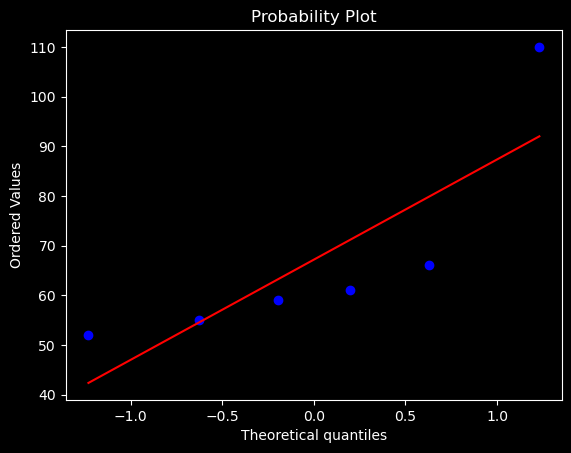

In [34]:
# Q-Q Plot
# 빨간선에 가깝게 데이터가 분포될 수록 정규성을 띈다.
stats.probplot(df['weight'], dist=stats.norm, plot=plt)
plt.show()

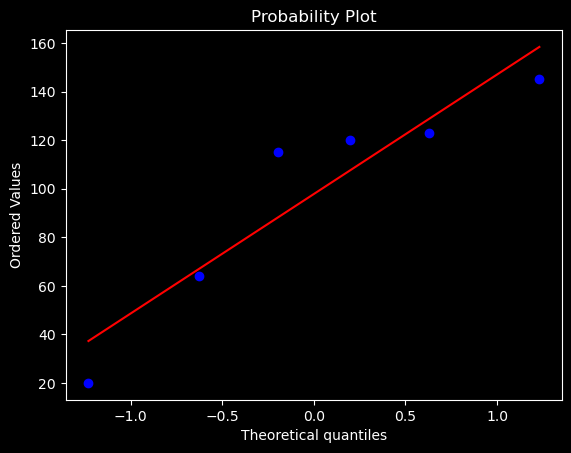

In [32]:
# 빨간선에 가깝게 데이터가 분포될 수록 정규성을 띈다.
stats.probplot(df['height'], dist=stats.norm, plot=plt)
plt.show()

In [28]:
import scipy.stats as stats

In [30]:
# pvalue가 0.05(5%) 보다 커야 정규성을 띈다.
shapiro_test = stats.shapiro(df['weight'])
shapiro_test

ShapiroResult(statistic=0.7093410491943359, pvalue=0.007742629386484623)

In [33]:
# pvalue가 0.05(5%) 보다 커야 정규성을 띈다.
shapiro_test = stats.shapiro(df['height'])
shapiro_test

ShapiroResult(statistic=0.8741567730903625, pvalue=0.2432829588651657)

In [60]:
# UCL, LCL 생성
df['UCL_W'] = df['weight'].mean() + 1*df['weight'].std()
df['LCL_W'] = df['weight'].mean() - 1*df['weight'].std()

df['UCL_H'] = df['height'].mean() + 1*df['height'].std()
df['LCL_H'] = df['height'].mean() - 1*df['height'].std()

In [61]:
# data 확인
df

,name,weight,height,UCL_W,LCL_W,UCL_H,LCL_H,weight_alarm,height_alarm
0,KATE,59,120,88.701909,45.631424,144.409794,51.256873,False,False
1,LOUISE,61,123,88.701909,45.631424,144.409794,51.256873,False,False
2,JANE,55,115,88.701909,45.631424,144.409794,51.256873,False,False
3,JASON,66,145,88.701909,45.631424,144.409794,51.256873,False,False
4,TOM,52,64,88.701909,45.631424,144.409794,51.256873,False,False
5,JACK,110,20,88.701909,45.631424,144.409794,51.256873,False,False


In [62]:
df["weight_alarm"] = ~((df['weight'] > df["LCL_W"]) & (df['weight'] < df["UCL_W"]))
df["height_alarm"] = ~((df['height'] > df["LCL_H"]) & (df['height'] < df["UCL_H"]))

In [63]:
df

,name,weight,height,UCL_W,LCL_W,UCL_H,LCL_H,weight_alarm,height_alarm
0,KATE,59,120,88.701909,45.631424,144.409794,51.256873,False,False
1,LOUISE,61,123,88.701909,45.631424,144.409794,51.256873,False,False
2,JANE,55,115,88.701909,45.631424,144.409794,51.256873,False,False
3,JASON,66,145,88.701909,45.631424,144.409794,51.256873,False,True
4,TOM,52,64,88.701909,45.631424,144.409794,51.256873,False,False
5,JACK,110,20,88.701909,45.631424,144.409794,51.256873,True,True


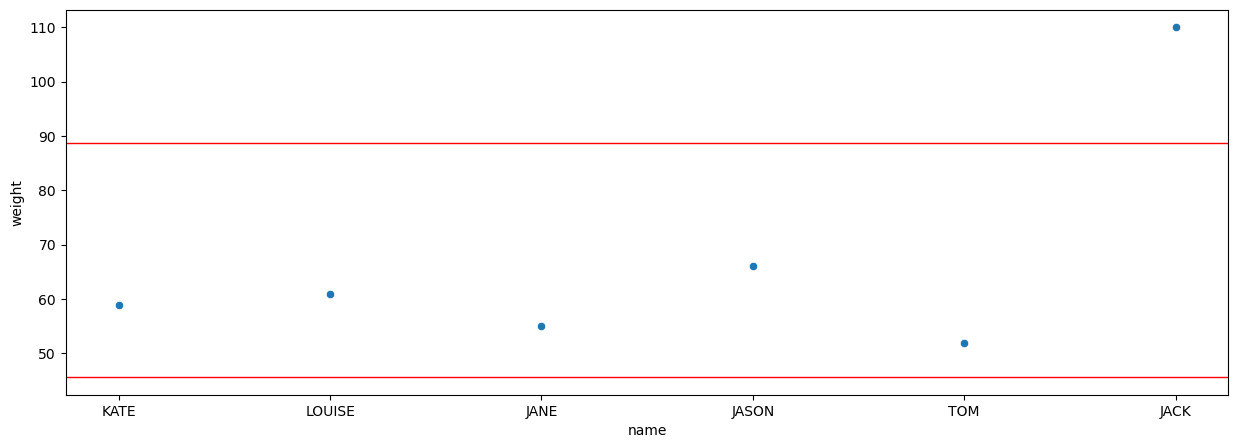

In [64]:
# weight plot 
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use(['dark_background'])

sns.scatterplot(x=df['name'], y=df['weight']);
plt.axhline(y=df['UCL_W'][0], color='r', linewidth=1)
plt.axhline(y=df['LCL_W'][0], color='r', linewidth=1)
plt.gcf().set_size_inches(15, 5)  #gcf() get current figure
#plt.figure(figsize=(20, 5))
plt.show()

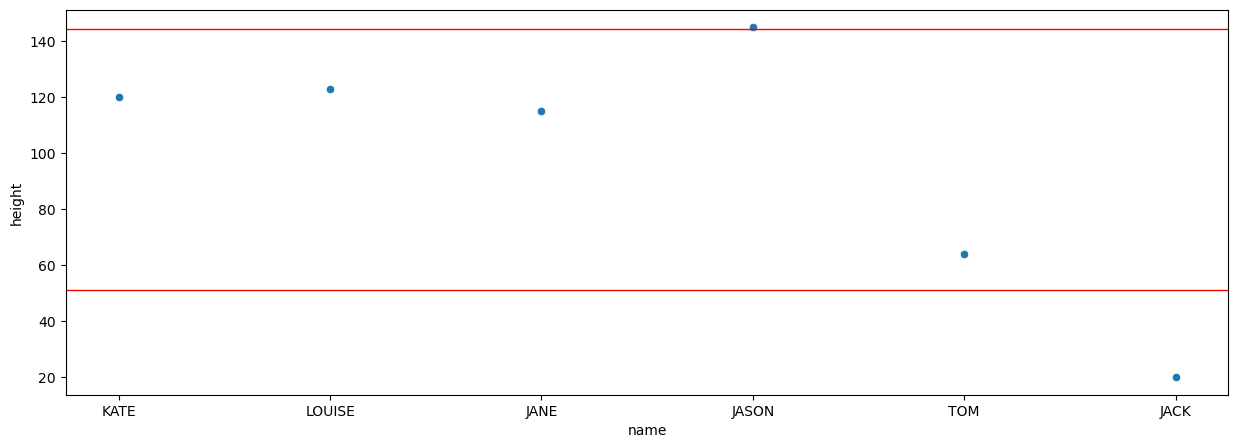

In [65]:
# height plot 
sns.scatterplot(x=df['name'], y=df['height']);
plt.axhline(y=df['UCL_H'][0], color='r', linewidth=1)
plt.axhline(y=df['LCL_H'][0], color='r', linewidth=1)
plt.gcf().set_size_inches(15, 5)
plt.show()

In [10]:
import seaborn as sns

In [11]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [13]:
dfi = sns.load_dataset('iris')

In [14]:
dfi.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [15]:
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [16]:
dfi['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [ ]:
# iris 데이터세트에서 각 컬럼별 3-시그마 룰을 적용해보세요.
# 정규성 검사, UCL, LCL 구하기
# 시각화
# 여기까지 하면 되는데, 
# 혹시나 추가로 species : setosa, versicolor, virginica 에 따라 3sigmal rule을 적용하는 건 어떨까요?

In [46]:
dfi["SL_UCL"] = dfi["sepal_length"].mean()+3*dfi['sepal_length'].std()
dfi

,sepal_length,sepal_width,petal_length,petal_width,species,SL_UCL
0,5.1,3.5,1.4,0.2,setosa,8.327532
1,4.9,3.0,1.4,0.2,setosa,8.327532
2,4.7,3.2,1.3,0.2,setosa,8.327532
3,4.6,3.1,1.5,0.2,setosa,8.327532
4,5.0,3.6,1.4,0.2,setosa,8.327532
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,8.327532
146,6.3,2.5,5.0,1.9,virginica,8.327532
147,6.5,3.0,5.2,2.0,virginica,8.327532
148,6.2,3.4,5.4,2.3,virginica,8.327532


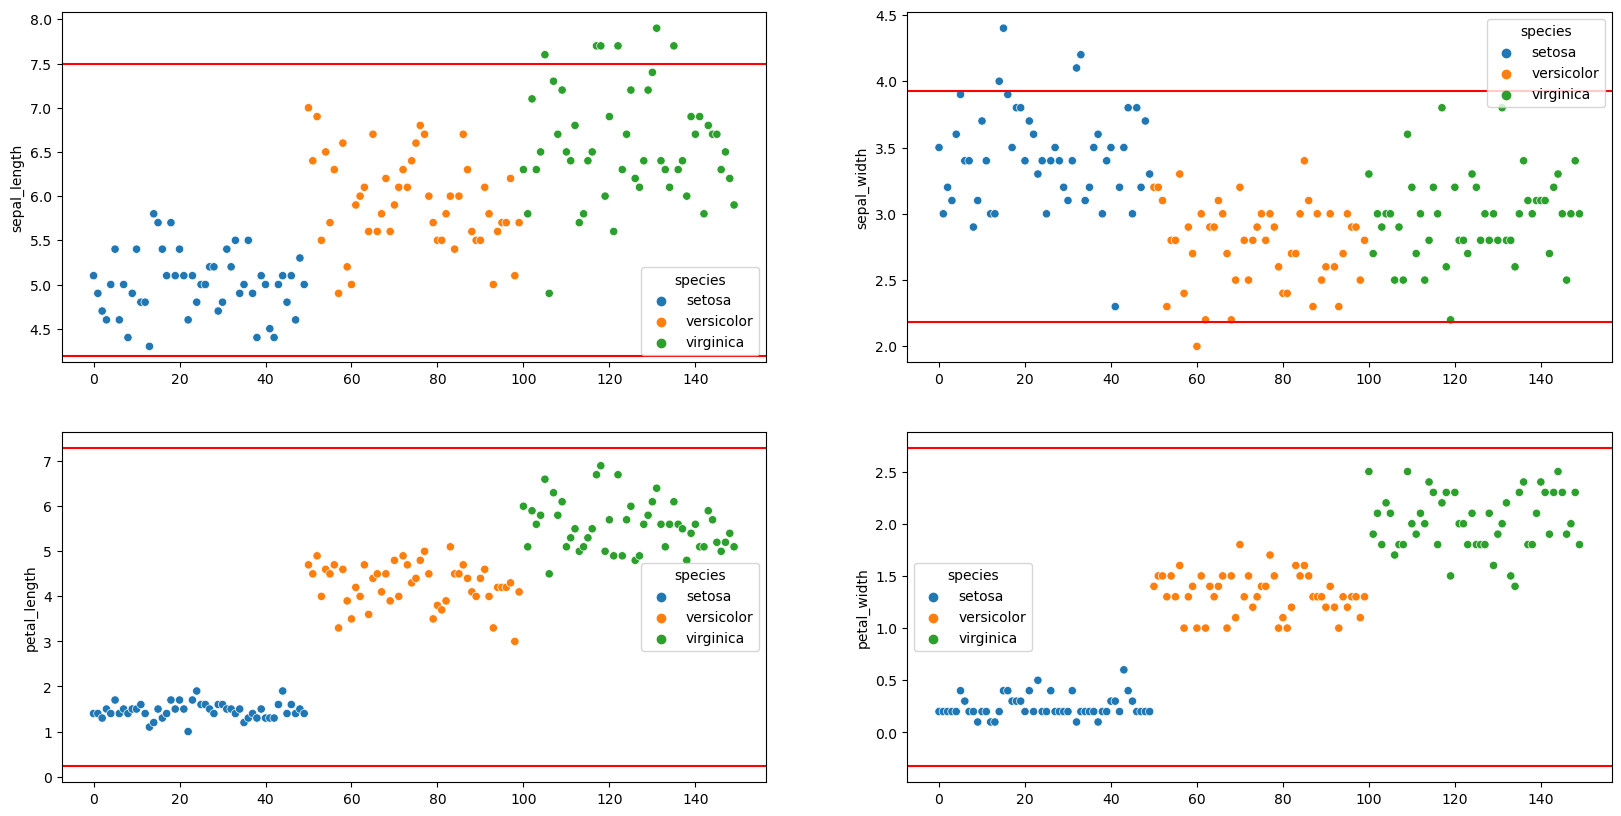

In [50]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
sns.scatterplot(x=dfi.index, y=dfi["sepal_length"], hue=dfi['species'])
plt.axhline(y=dfi["sepal_length"].mean()+2*dfi['sepal_length'].std(), color='r')
plt.axhline(y=dfi["sepal_length"].mean()-2*dfi['sepal_length'].std(), color='r')
plt.subplot(2, 2, 2)
sns.scatterplot(x=dfi.index, y=dfi["sepal_width"], hue=dfi['species'])
plt.axhline(y=dfi["sepal_width"].mean()+2*dfi['sepal_width'].std(), color='r')
plt.axhline(y=dfi["sepal_width"].mean()-2*dfi['sepal_width'].std(), color='r')
plt.subplot(2, 2, 3)
sns.scatterplot(x=dfi.index, y=dfi["petal_length"], hue=dfi['species'])
plt.axhline(y=dfi["petal_length"].mean()+2*dfi['petal_length'].std(), color='r')
plt.axhline(y=dfi["petal_length"].mean()-2*dfi['petal_length'].std(), color='r')
plt.subplot(2, 2, 4)
sns.scatterplot(x=dfi.index, y=dfi["petal_width"], hue=dfi['species'])
plt.axhline(y=dfi["petal_width"].mean()+2*dfi['petal_width'].std(), color='r')
plt.axhline(y=dfi["petal_width"].mean()-2*dfi['petal_width'].std(), color='r')
plt.show()